### Get ground truth affine transformation for selected samples
1. Create QuPath projects and annotate corresponding landmark pairs
2. Export the annotated points to csv files (export_anno_points.groovy)
3. Read source and target points from the csv files, and calculate transformation
4. Save affine transformation into a file

In [13]:
import os
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import pickle
import glob

Processing A-22_align_anno.csv
Rotate: 0.003588 degrees 0.205562
Scale: 0.678745.
Translation: (x=92.047393, y=98.813167). Shift distance: 135.043565


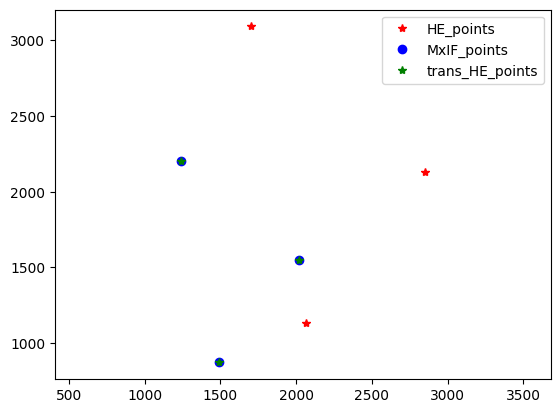

Processing A-8_align_anno.csv
Rotate: 0.002472 degrees 0.141635
Scale: 0.678217.
Translation: (x=-10.931284, y=145.630139). Shift distance: 146.039825


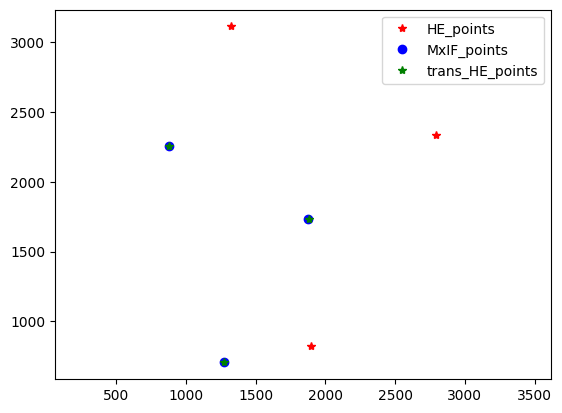

Processing B-11_align_anno.csv
Rotate: 0.002777 degrees 0.159133
Scale: 0.677450.
Translation: (x=98.128587, y=153.725285). Shift distance: 182.375115


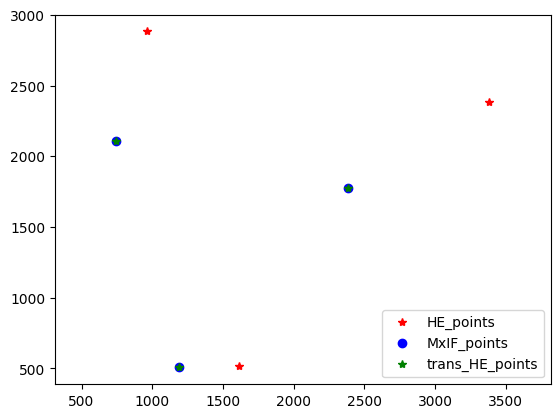

Processing B-12_align_anno.csv
Rotate: 0.010690 degrees 0.612495
Scale: 0.706144.
Translation: (x=30.721245, y=-108.983321). Shift distance: 113.230558


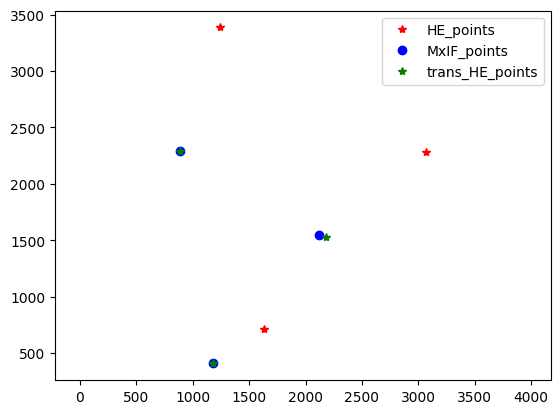

Processing B-15_align_anno.csv
Rotate: 0.003024 degrees 0.173254
Scale: 0.678113.
Translation: (x=85.518631, y=45.540482). Shift distance: 96.888450


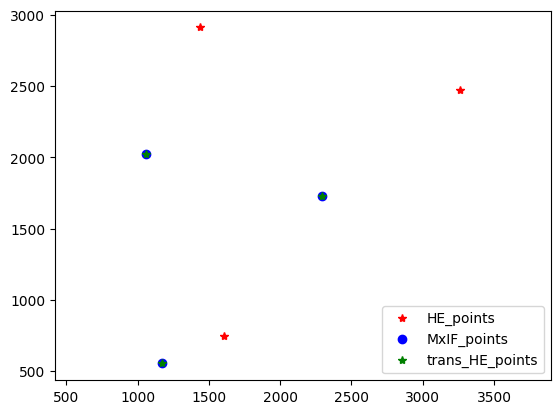

Processing B-21_align_anno.csv
Rotate: 0.002868 degrees 0.164315
Scale: 0.677107.
Translation: (x=-20.101318, y=181.444437). Shift distance: 182.554504


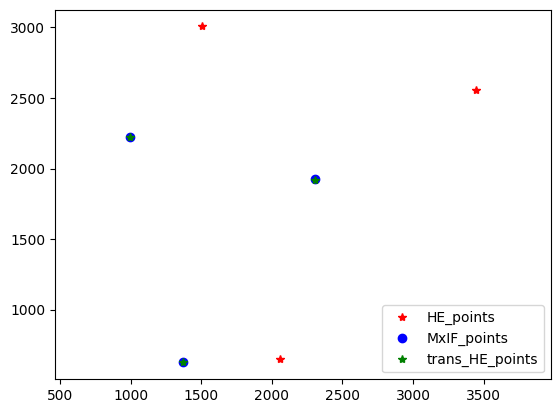

Processing B-9_align_anno.csv
Rotate: 0.003721 degrees 0.213201
Scale: 0.678972.
Translation: (x=132.238377, y=104.685139). Shift distance: 168.659321


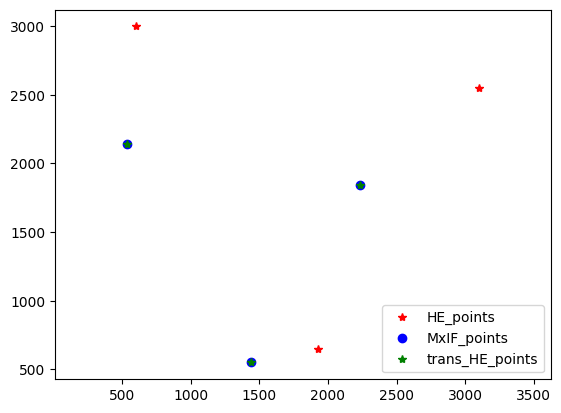

Processing C-10_align_anno.csv
Rotate: 0.003634 degrees 0.208206
Scale: 0.678045.
Translation: (x=67.067131, y=136.323675). Shift distance: 151.928090


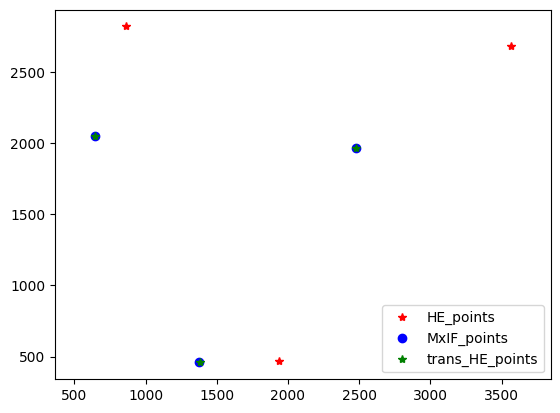

Processing C-15_align_anno.csv
Rotate: 0.002239 degrees 0.128259
Scale: 0.677143.
Translation: (x=35.178409, y=67.969922). Shift distance: 76.533854


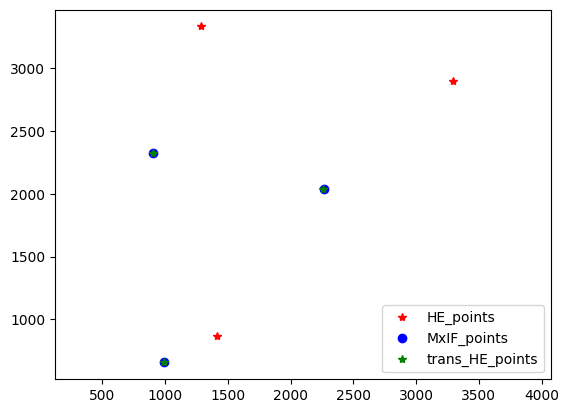

Processing C-21_align_anno.csv
Rotate: 0.000294 degrees 0.016835
Scale: 0.678575.
Translation: (x=43.815086, y=60.703448). Shift distance: 74.864346


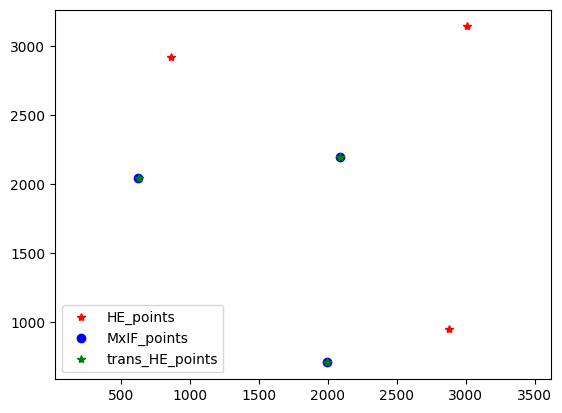

Processing C-24_align_anno.csv
Rotate: 0.005193 degrees 0.297520
Scale: 0.677909.
Translation: (x=51.091556, y=75.574110). Shift distance: 91.223863


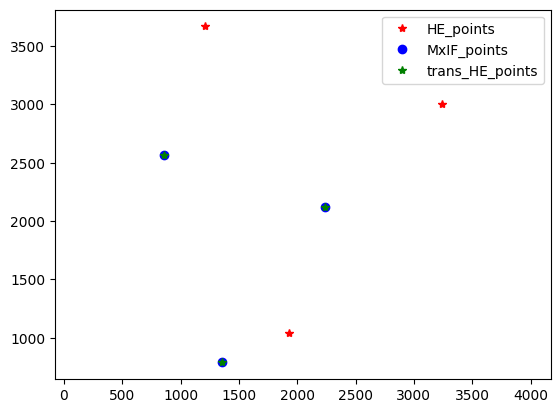

Processing D-6_align_anno.csv
Rotate: 0.003153 degrees 0.180655
Scale: 0.676220.
Translation: (x=177.467615, y=239.472041). Shift distance: 298.063102


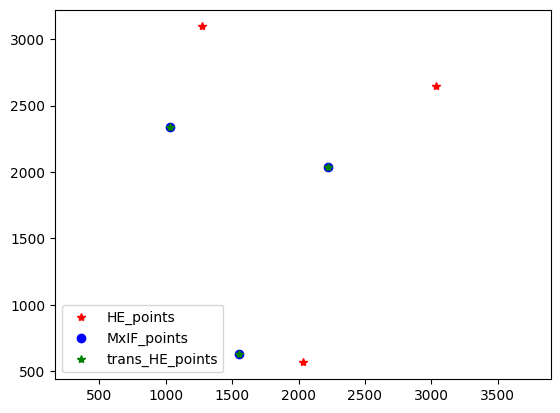

Processing E-13_align_anno.csv
Rotate: -0.000614 degrees -0.035187
Scale: 0.679274.
Translation: (x=44.267410, y=28.170993). Shift distance: 52.471025


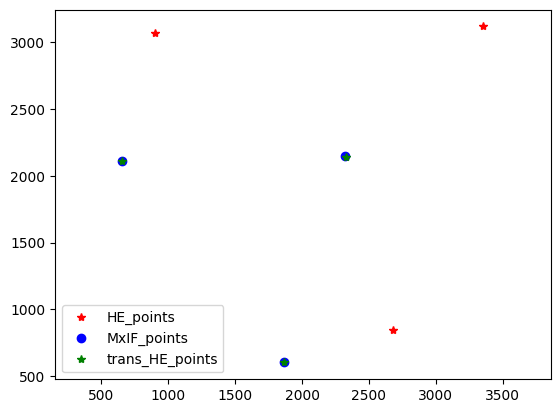

Processing F-10_align_anno.csv
Rotate: 0.001154 degrees 0.066123
Scale: 0.679564.
Translation: (x=5.130669, y=50.184142). Shift distance: 50.445732


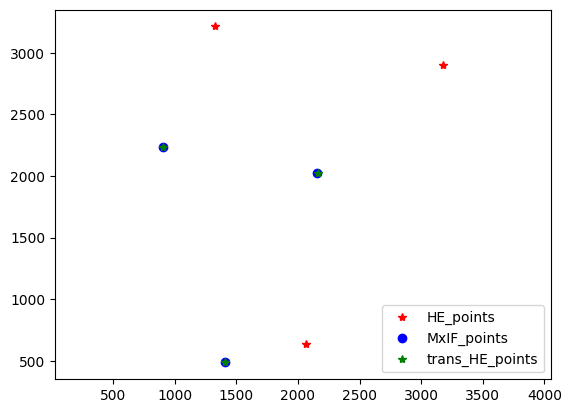

Processing G-7_align_anno.csv
Rotate: 0.001389 degrees 0.079558
Scale: 0.677646.
Translation: (x=57.598908, y=103.130717). Shift distance: 118.125268


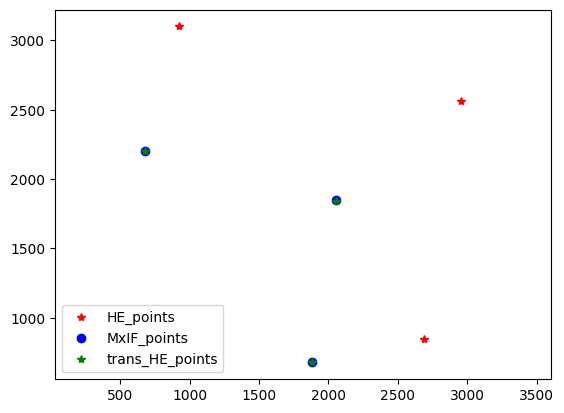

Processing H-13_align_anno.csv
Rotate: 0.001211 degrees 0.069363
Scale: 0.677107.
Translation: (x=30.473233, y=143.723416). Shift distance: 146.918475


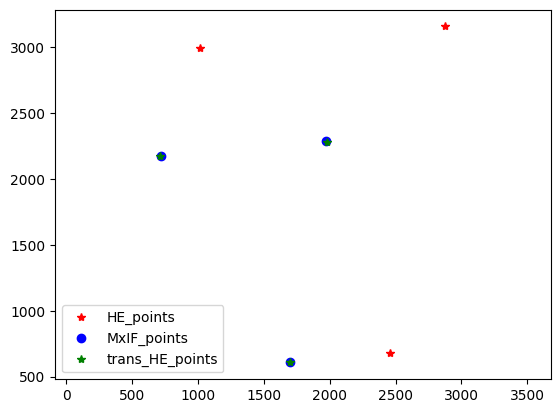

Processing H-16_align_anno.csv
Rotate: 0.009753 degrees 0.558832
Scale: 0.678113.
Translation: (x=32.864854, y=-97.573933). Shift distance: 102.960046


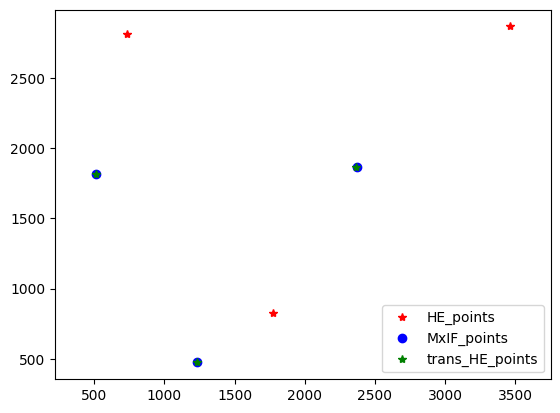

Processing H-20_align_anno.csv
Rotate: 0.001294 degrees 0.074123
Scale: 0.678519.
Translation: (x=85.437890, y=-14.020867). Shift distance: 86.580700


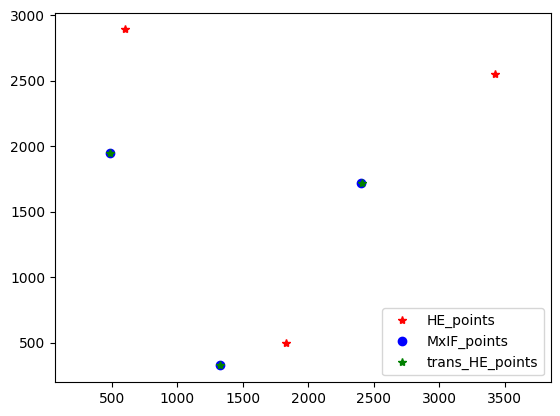

Processing I-15_align_anno.csv
Rotate: 0.002738 degrees 0.156893
Scale: 0.680529.
Translation: (x=-41.439784, y=17.047897). Shift distance: 44.809446


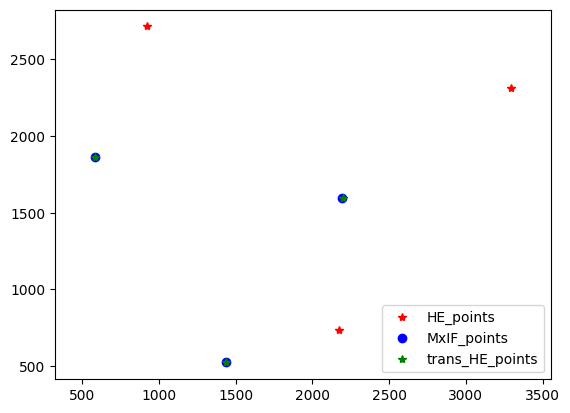

Processing I-17_align_anno.csv
Rotate: -0.000878 degrees -0.050295
Scale: 0.675699.
Translation: (x=38.259915, y=-14.552113). Shift distance: 40.933911


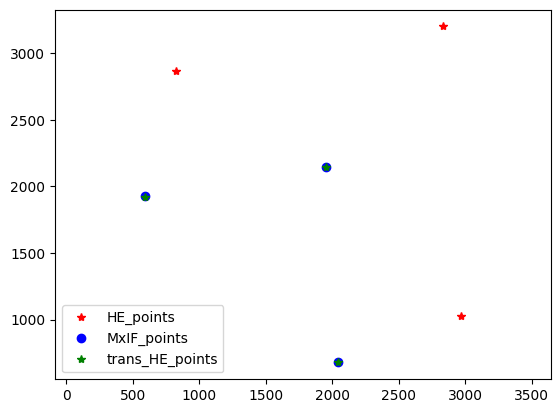

In [14]:
#Sec1
ground_truth_output_dir = r"\\mfad\researchmn\HCPR\HCPR-GYNECOLOGICALTUMORMICROENVIRONMENT\Archive\WSIs\Ovarian_TMA\AlignmentEval\Sec1GroundTruth"
HE_export_dir = r"\\mfad\researchmn\HCPR\HCPR-GYNECOLOGICALTUMORMICROENVIRONMENT\Archive\WSIs\Ovarian_TMA\AlignmentEval\QuPathAnnoProj_HE_Sec1\export"
#Sec2
# ground_truth_output_dir = r"\\mfad\researchmn\HCPR\HCPR-GYNECOLOGICALTUMORMICROENVIRONMENT\Archive\WSIs\Ovarian_TMA\AlignmentEval\Sec2GroundTruth"
# HE_export_dir = r"\\mfad\researchmn\HCPR\HCPR-GYNECOLOGICALTUMORMICROENVIRONMENT\Archive\WSIs\Ovarian_TMA\AlignmentEval\QuPathAnnoProj_HE_Sec2\export"

MxIF_export_dir = r"\\mfad\researchmn\HCPR\HCPR-GYNECOLOGICALTUMORMICROENVIRONMENT\Archive\WSIs\Ovarian_TMA\AlignmentEval\QuPathAnnoProj_MxIF\export"

file_name_list_with_path = glob.glob(os.path.join(HE_export_dir, "*align_anno.csv"))
file_name_list = [os.path.split(i)[1] for i in file_name_list_with_path]

# TODO: After transformation, compare the metrics from annotation and

#########################################
# for debug
DEBUG = True
# DEBUG = False
#########################################

for fn in file_name_list:
    print("Processing %s" % fn)
    roi_id = fn.split("_")[0]
    # Please note: The point location is exported as pixels, not microns
    HE_points_fn = os.path.join(HE_export_dir, fn)
    MxIF_points_fn = os.path.join(MxIF_export_dir, fn)

    with open(HE_points_fn) as f:
        lines = (line for line in f if not line.startswith('x'))
        HE_points = np.loadtxt(lines, delimiter=',', skiprows=0)
    with open(MxIF_points_fn) as f:
        lines = (line for line in f if not line.startswith('x'))
        MxIF_points = np.loadtxt(lines, delimiter=',', skiprows=0)

    src_points = HE_points.astype(np.float32)
    dst_points = MxIF_points.astype(np.float32)
    
    M = cv2.estimateAffinePartial2D(src_points, dst_points)[0]
    theta = math.atan(M[1, 0]/M[0, 0])
    degrees = theta * ( 180.0 / math.pi )
    s = M[0, 0]/math.cos(theta)
    delta = math.sqrt(M[0, 2]**2 + M[1, 2]**2)
    
    # For debug
    if DEBUG: 
        print("Rotate: %f degrees %f" % (theta, degrees))
        print("Scale: %f." % s)
        print("Translation: (x=%f, y=%f). Shift distance: %f" % (M[0, 2], M[1, 2],delta))
    
    MM = np.vstack((M,np.array([0,0,1])))
    new_XY = np.vstack((np.transpose(HE_points), np.ones((1, len(HE_points)))))
    transformed_loc = np.dot(M, new_XY)
    transformed_HE_points = np.transpose(transformed_loc[0:2, :])
    
    if DEBUG: 
        plt.plot(HE_points[:, 0], HE_points[:, 1], 'r*')
        plt.plot(MxIF_points[:, 0], MxIF_points[:, 1], 'bo')
        plt.plot(transformed_HE_points[:, 0], transformed_HE_points[:, 1], 'g*')
        plt.axis('equal')
        plt.legend(["HE_points", "MxIF_points", "trans_HE_points"])
        plt.show()
    
    trans_fn = os.path.join(ground_truth_output_dir, roi_id + "_trans.dat")
    data = [theta, degrees, s, delta, M]
    with open(trans_fn, "wb") as f:
        pickle.dump(data, f)

####
Estimated transformation matrix is:
```
[cos(theta)*s, -sin(theta)*s, tx;
 sin(theta)*s,  cos(theta)*s, ty]
 ```
https://amroamroamro.github.io/mexopencv/matlab/cv.estimateAffinePartial2D.html

### Big Question
Do I need to do some conversion? as the affine transformation is 
 obtained from point matrix alignment, coordinate is diffewrnt from image matrix

###
should be right, as in QuPath the um coordinate starts from top left (like image matrix), not from bottom left (like Euclidean coordinate system)
1) In Cell measurements export, the cell centroids are saved as microns (um)
2) In the point annotation export, the landmarks are saved as pixels